Importing required libraries

In [212]:
# to silence/ignore the warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,roc_auc_score,precision_score,f1_score,recall_score,roc_curve,auc
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,fbeta_score,matthews_corrcoef
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC 
import xgboost as xgb
from scipy import stats

Loading and pre-processing of the dataset

In [213]:
# reading the dataset
df = pd.read_csv('heart_statlog_cleveland.csv')

In [214]:
df.head(10)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
5,39,1,3,120,339,0,0,170,0,0.0,1,0
6,45,0,2,130,237,0,0,170,0,0.0,1,0
7,54,1,2,110,208,0,0,142,0,0.0,1,0
8,37,1,4,140,207,0,0,130,1,1.5,2,1
9,48,0,2,120,284,0,0,120,0,0.0,1,0


In [215]:
# renaming the columns/features and giving them underscore for easy usage in further processing
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope','target']

In [216]:
# checking the unique values for each column
df.nunique()

age                         50
sex                          2
chest_pain_type              4
resting_blood_pressure      67
cholesterol                222
fasting_blood_sugar          2
rest_ecg                     3
max_heart_rate_achieved    119
exercise_induced_angina      2
st_depression               53
st_slope                     4
target                       2
dtype: int64

In [217]:
# creating a dictionary to map the original numerical values to the new categorical values
chest_pain_mapping = {1: 'typical angina', 2: 'atypical angina', 3: 'non-anginal pain', 4: 'asymptomatic'}
rest_ecg_mapping = {0: 'normal', 1: 'ST-T wave abnormality', 2: 'left ventricular hypertrophy'}
st_slope_mapping = {0: 'normal', 1: 'upsloping', 2: 'flat', 3: 'downsloping'}

# Using the replace function to apply the mappings to the respective columns
df['chest_pain_type'] = df['chest_pain_type'].replace(chest_pain_mapping)
df['rest_ecg'] = df['rest_ecg'].replace(rest_ecg_mapping)
df['st_slope'] = df['st_slope'].replace(st_slope_mapping)

In [218]:
# Converting 'sex' column to categorical using map function
df['sex'] = df['sex'].map({1: 'male', 0: 'female'})

In [219]:
# viewing the updated dataframe
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,target
0,40,male,atypical angina,140,289,0,normal,172,0,0.0,upsloping,0
1,49,female,non-anginal pain,160,180,0,normal,156,0,1.0,flat,1
2,37,male,atypical angina,130,283,0,ST-T wave abnormality,98,0,0.0,upsloping,0
3,48,female,asymptomatic,138,214,0,normal,108,1,1.5,flat,1
4,54,male,non-anginal pain,150,195,0,normal,122,0,0.0,upsloping,0


In [220]:
# let's see the distribution of each unique value in each column
# looping through each categorical column and printing the counts of all unique values
for column in df.columns:
    if df[column].dtype == 'object': #or pd.api.types.is_categorical_dtype(df[column]):
        print(f"Counts of unique values in {column}:")
        print(df[column].value_counts())
        print()  # adding an empty line for readability

Counts of unique values in sex:
male      909
female    281
Name: sex, dtype: int64

Counts of unique values in chest_pain_type:
asymptomatic        625
non-anginal pain    283
atypical angina     216
typical angina       66
Name: chest_pain_type, dtype: int64

Counts of unique values in rest_ecg:
normal                          684
left ventricular hypertrophy    325
ST-T wave abnormality           181
Name: rest_ecg, dtype: int64

Counts of unique values in st_slope:
flat           582
upsloping      526
downsloping     81
normal           1
Name: st_slope, dtype: int64



In [221]:
# since there is only one row/value that corresponds normal in st_slope, let's drop it for data balance
df = df[df['st_slope'] != 'normal']

In [222]:
# checking distribution after dropping normal
df['st_slope'].value_counts()

flat           582
upsloping      526
downsloping     81
Name: st_slope, dtype: int64

In [223]:
# checking for missing/na values in each column
df.isna().sum()

age                        0
sex                        0
chest_pain_type            0
resting_blood_pressure     0
cholesterol                0
fasting_blood_sugar        0
rest_ecg                   0
max_heart_rate_achieved    0
exercise_induced_angina    0
st_depression              0
st_slope                   0
target                     0
dtype: int64

In [224]:
# shape of the dataset
df.shape

(1189, 12)

In [225]:
# getting the summary statistics of numerical columns
df.describe(include =[np.number])

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,target
count,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000
mean,53.708158,132.138772,210.376787,0.212784,139.739277,0.387721,0.923549,0.528175
std,9.352961,18.369251,101.462185,0.409448,25.527386,0.487435,1.086464,0.499416
min,28.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,120.000000,188.000000,0.000000,121.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,229.000000,0.000000,141.000000,0.000000,0.600000,1.000000
75%,60.000000,140.000000,270.000000,0.000000,160.000000,1.000000,1.600000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


In [226]:
# we can see from the summary statistics that they are outliers in blood pressure and cholesterol column

# selecting only the numeric columns
numerical_columns = df.select_dtypes(include=np.number).columns

# Remove the target column from the list of numerical columns
numerical_columns = numerical_columns.drop('target')

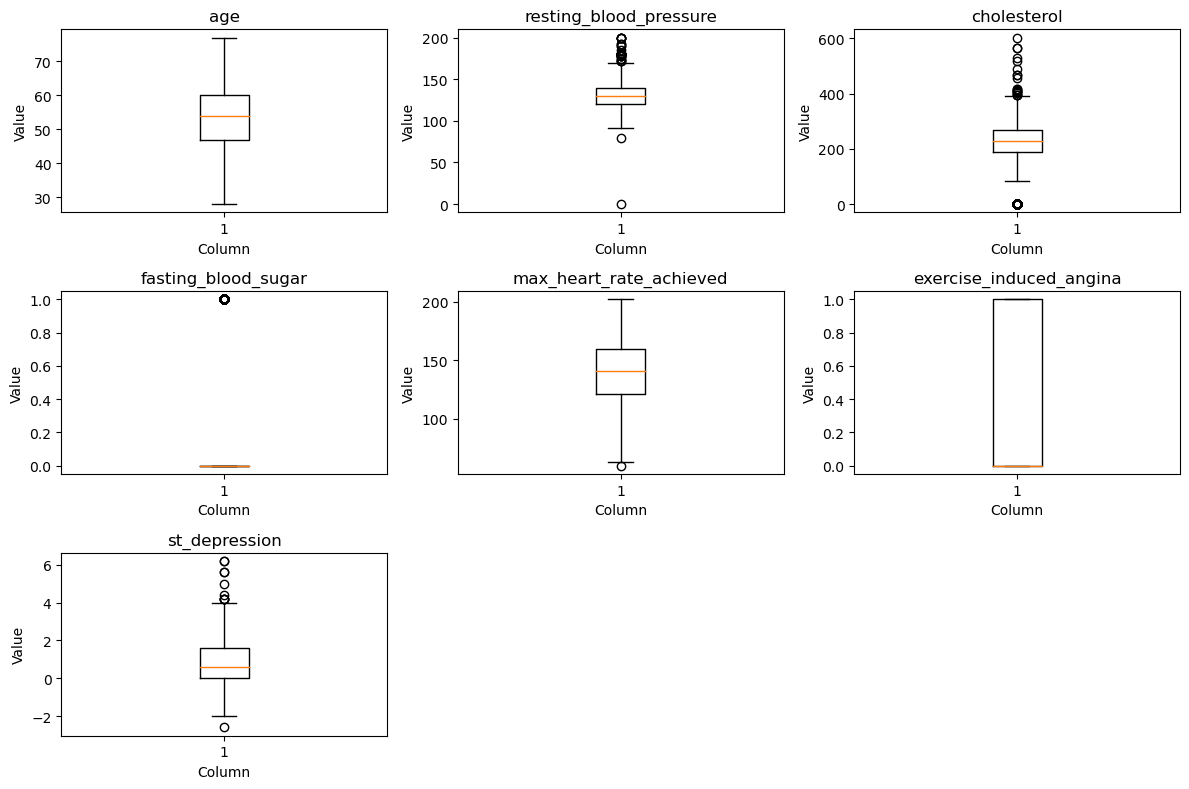

In [227]:
# Create box plots for each numerical column
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)  # Adjust subplot layout
    plt.boxplot(df[column])
    plt.title(column)
    plt.xlabel('Column')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [228]:
# Calculating z-scores for each numerical column and getting the absolute values 
z_scores = np.abs(stats.zscore(df[numerical_columns]))

In [229]:
# defining a threshold to drop the outliers
threshold = 3

In [230]:
#getting the indices of the rows with the z scores above threshold
outlier_indices = np.where(z_scores > threshold)

In [231]:
# unique indices
outlier_rows = np.unique(outlier_indices[0])

In [232]:
# filtering the main dataframe of all the outliers
df = df.drop(outlier_rows)

In [233]:
# looking at the dimensions of the dataset after filtering
df.shape

(1161, 12)

In [234]:
# getting the summary statistics of numerical columns after filtering
df.describe(include =[np.number])

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,target
count,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000
mean,53.712317,132.129199,210.139535,0.213609,139.957795,0.390181,0.928338,0.527132
std,9.359299,17.599388,99.898032,0.410030,25.365211,0.488001,1.081776,0.499478
min,28.000000,80.000000,0.000000,0.000000,67.000000,0.000000,-2.000000,0.000000
25%,47.000000,120.000000,188.000000,0.000000,121.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,229.000000,0.000000,141.000000,0.000000,0.600000,1.000000
75%,60.000000,140.000000,270.000000,0.000000,160.000000,1.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,1.000000


Exploratory data analysis

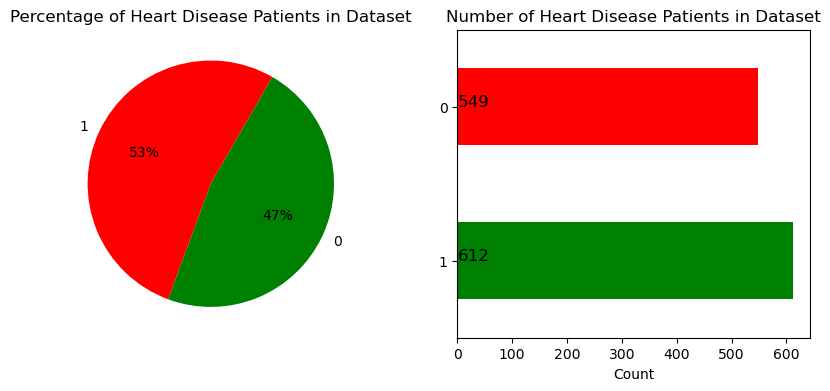

In [235]:
# let's look at the distribution of target column between heart disease risk and normal(no risk)

# defining the colors for the graph
colors = ['red', 'green']

# defining figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10,4))

# Plotting pie chart (percentage)
df['target'].value_counts().plot.pie(ax=ax1, autopct="%1.0f%%", startangle=60, colors=colors)
ax1.set(title='Percentage of Heart Disease Patients in Dataset', ylabel='')

# Plot horizontal bar chart (count)
df["target"].value_counts().plot(kind="barh", ax=ax2, color=colors[::-1])
for i, j in enumerate(df["target"].value_counts().values):
    ax2.text(.5, i, j, fontsize=12)
ax2.set(title='Number of Heart Disease Patients in Dataset', ylabel='', xlabel='Count')

plt.show()

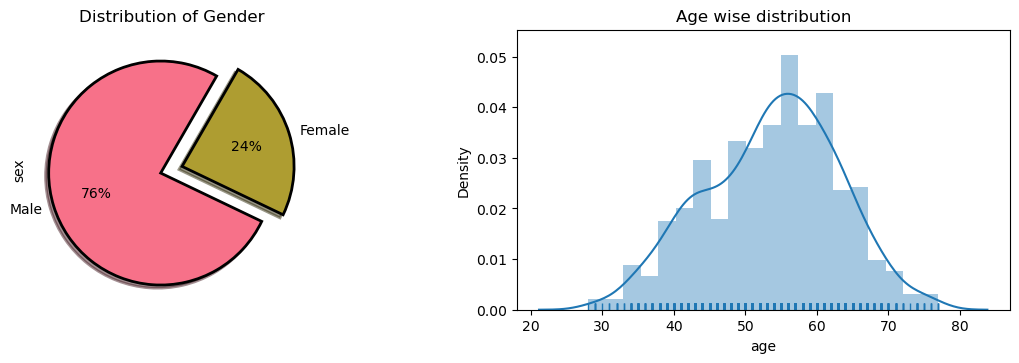

In [236]:
# let's look at the gender and age distribution
 
# Creating a new figure with a specified size
plt.figure(figsize=(14,8))

# Creating a subplot (2 rows, 2 columns, first subplot)
plt.subplot(221)

# Plotting a pie chart for the distribution of gender
df["sex"].value_counts().plot.pie(autopct="%1.0f%%", colors=sns.color_palette("husl", 5), startangle=60,
                                   labels=["Male", "Female"], wedgeprops={"linewidth": 2, "edgecolor": "k"},
                                   explode=[.1, .1], shadow=True)

# Setting the title of the first subplot
plt.title("Distribution of Gender")

# Creating a subplot (2 rows, 2 columns, second subplot)
plt.subplot(222)

# Creating a distribution plot for the 'age' column
ax = sns.distplot(df['age'], rug=True)

# Setting the title of the second subplot
plt.title("Age wise distribution")

# Displaying the plot
plt.show()

In [237]:
# splitting the dataframe into normal and heart risk
attr_1=df[df['target']==1]

attr_0=df[df['target']==0]

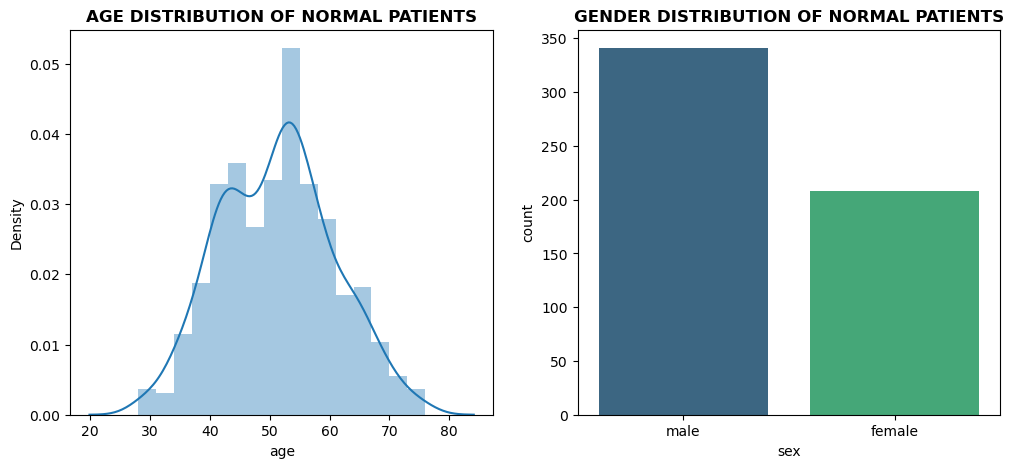

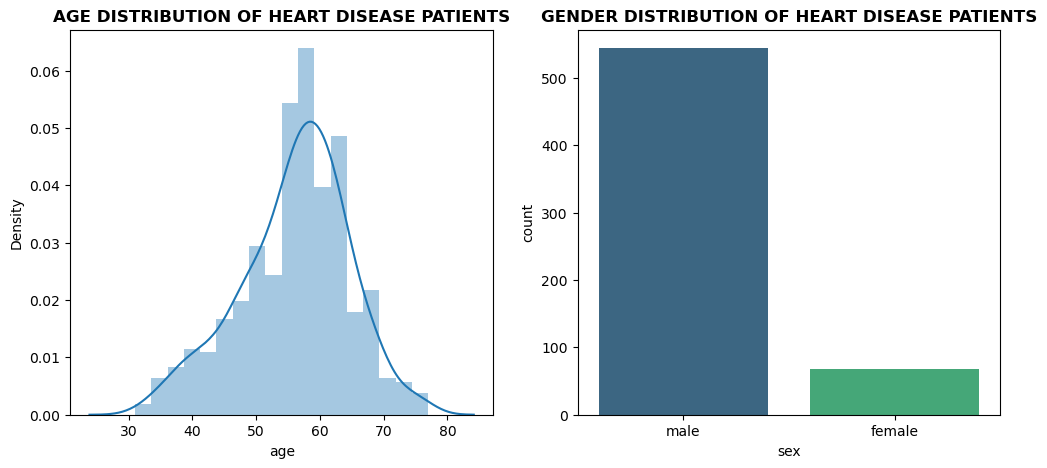

In [238]:
# Plotting gender distribution of patients without heart disease
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.distplot(attr_0['age'])
plt.title('AGE DISTRIBUTION OF NORMAL PATIENTS', fontsize=12, weight='bold')

# Plotting gender distribution of patients without heart disease
ax2 = plt.subplot2grid((1,2),(0,1))
sns.countplot(data=attr_0, x='sex', palette='viridis', order=['male', 'female'])  # Specify order of categories
plt.title('GENDER DISTRIBUTION OF NORMAL PATIENTS', fontsize=12, weight='bold')
plt.show()

# Plotting age distribution of patients with heart disease
fig = plt.figure(figsize=(12,5))
ax3 = plt.subplot2grid((1,2),(0,0))
sns.distplot(attr_1['age'])
plt.title('AGE DISTRIBUTION OF HEART DISEASE PATIENTS', fontsize=12, weight='bold')

# Plotting gender distribution of patients with heart disease
ax4 = plt.subplot2grid((1,2),(0,1))
sns.countplot(data=attr_1, x='sex', palette='viridis', order=['male', 'female'])  # Specify order of categories
plt.title('GENDER DISTRIBUTION OF HEART DISEASE PATIENTS', fontsize=12, weight='bold')
plt.show()

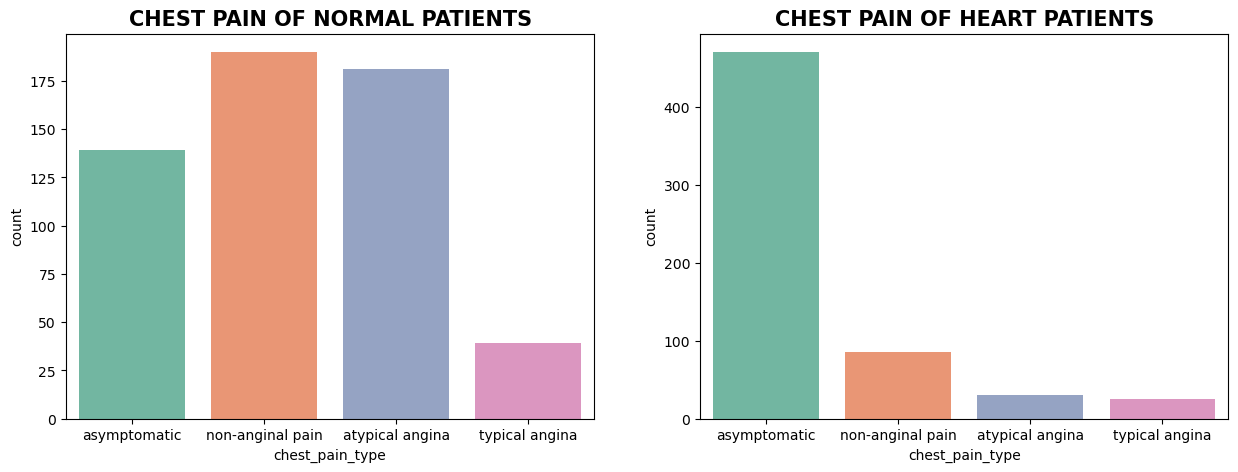

In [239]:
# Reordering the categories
ordered_categories = ['asymptomatic', 'non-anginal pain', 'atypical angina', 'typical angina']

# Plotting chest pain distribution of normal patients
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(x='chest_pain_type', data=attr_0, order=ordered_categories, palette='Set2')
plt.title('CHEST PAIN OF NORMAL PATIENTS', fontsize=15, weight='bold')

# Plotting chest pain distribution of heart patients
ax2 = plt.subplot2grid((1,2),(0,1))
sns.countplot(x='chest_pain_type', data=attr_1, order=ordered_categories, palette='Set2')
plt.title('CHEST PAIN OF HEART PATIENTS', fontsize=15, weight='bold' )
plt.show()

In [240]:
# exploring the Heart Disease patients based on Chest Pain Type
plot_criteria= ['chest_pain_type', 'target']
cm = sns.light_palette("red", as_cmap=True)
(round(pd.crosstab(df[plot_criteria[0]], df[plot_criteria[1]], normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

target,0,1
chest_pain_type,,
asymptomatic,25.320000,76.960000
atypical angina,32.970000,4.900000
non-anginal pain,34.610000,14.050000
typical angina,7.100000,4.080000


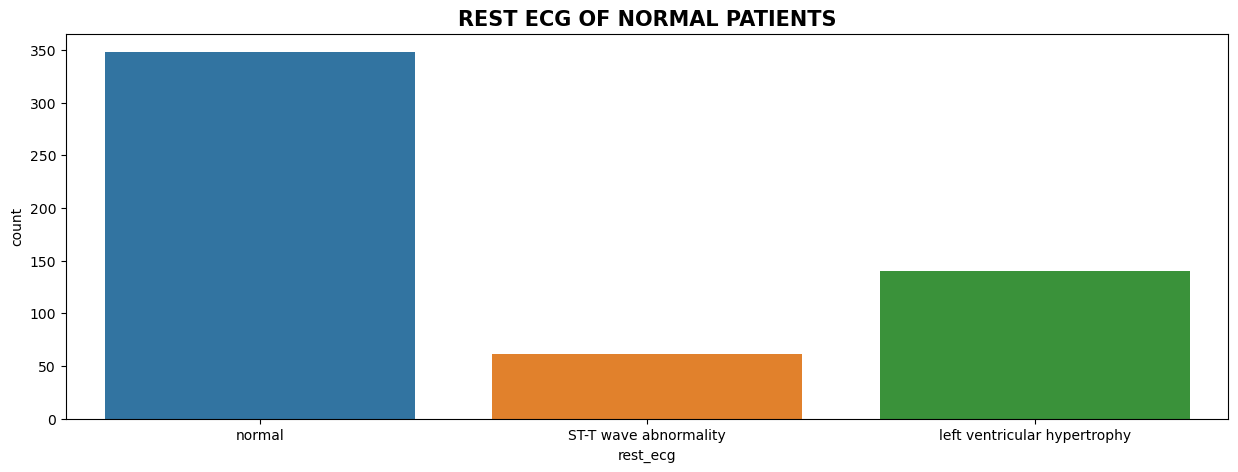

In [241]:
plt.figure(figsize=(15,5))
sns.countplot(data=attr_0, x='rest_ecg')
plt.title('REST ECG OF NORMAL PATIENTS', fontsize=15, weight='bold')
plt.show()


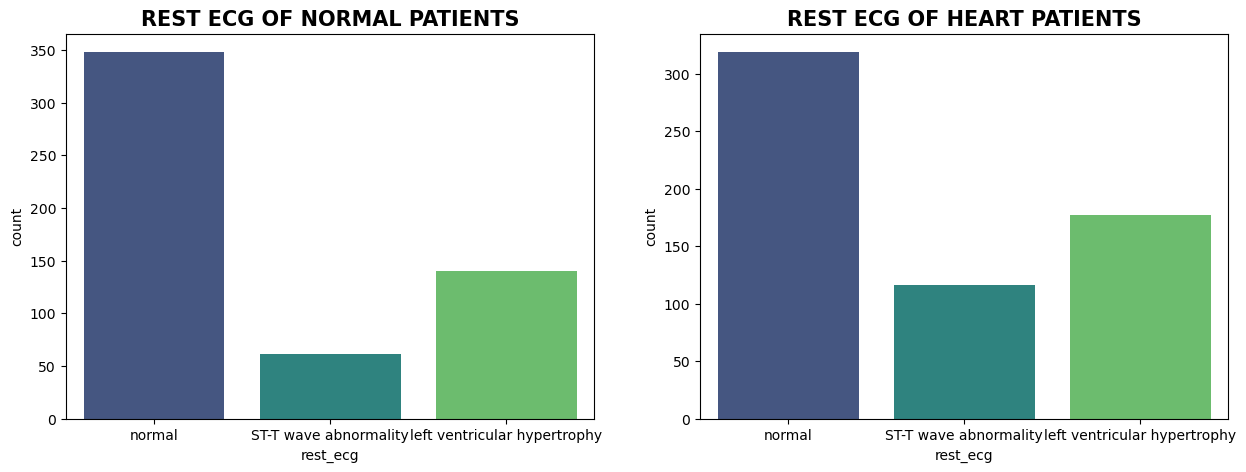

In [242]:
# plotting normal patients
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(data=attr_0, x='rest_ecg', palette='viridis')
plt.title('REST ECG OF NORMAL PATIENTS', fontsize=15, weight='bold')

#plotting heart patients
ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(data = attr_1, x = 'rest_ecg' ,palette='viridis')
plt.title('REST ECG OF HEART PATIENTS', fontsize=15, weight='bold' )
plt.show()

In [243]:
#Exploring the Heart Disease patients based on REST ECG
plot_criteria= ['rest_ecg', 'target']
cm = sns.light_palette("red", as_cmap=True)
(round(pd.crosstab(df[plot_criteria[0]], df[plot_criteria[1]], normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

target,0,1
rest_ecg,,
ST-T wave abnormality,11.110000,18.950000
left ventricular hypertrophy,25.500000,28.920000
normal,63.390000,52.120000


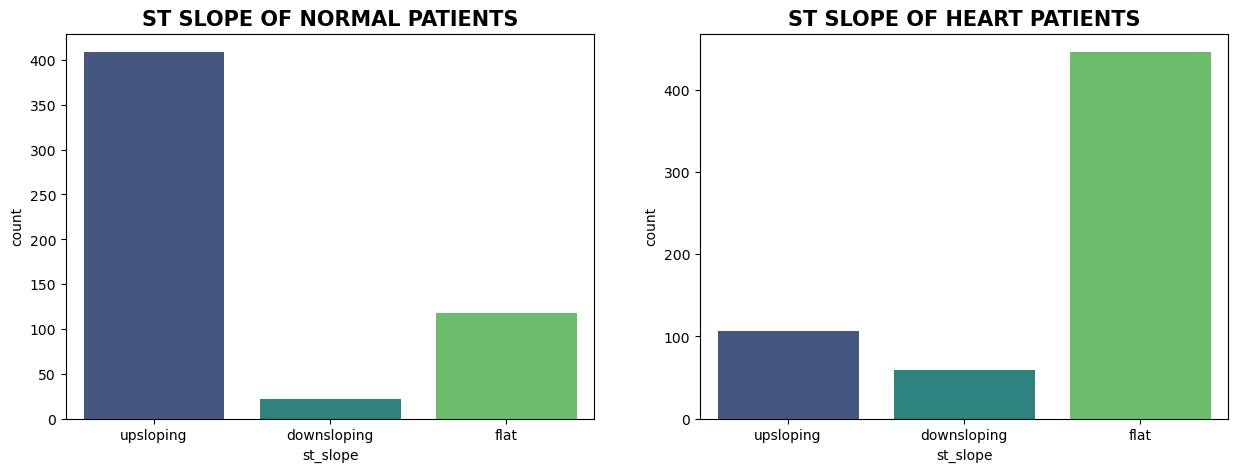

In [244]:
# Defining the desired order of x values
order = ['upsloping', 'downsloping', 'flat']

# Plotting normal patients
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(data=attr_0, x='st_slope', palette='viridis', order=order)
plt.title('ST SLOPE OF NORMAL PATIENTS', fontsize=15, weight='bold')

# Plotting heart patients
ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(data=attr_1, x='st_slope', palette='viridis', order=order)
plt.title('ST SLOPE OF HEART PATIENTS', fontsize=15, weight='bold')
plt.show()

In [245]:
#Exploring the Heart Disease patients based on ST Slope
plot_criteria= ['st_slope', 'target']
cm = sns.light_palette("red", as_cmap=True)
(round(pd.crosstab(df[plot_criteria[0]], df[plot_criteria[1]], normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

target,0,1
st_slope,,
downsloping,4.010000,9.640000
flat,21.490000,72.880000
upsloping,74.500000,17.480000


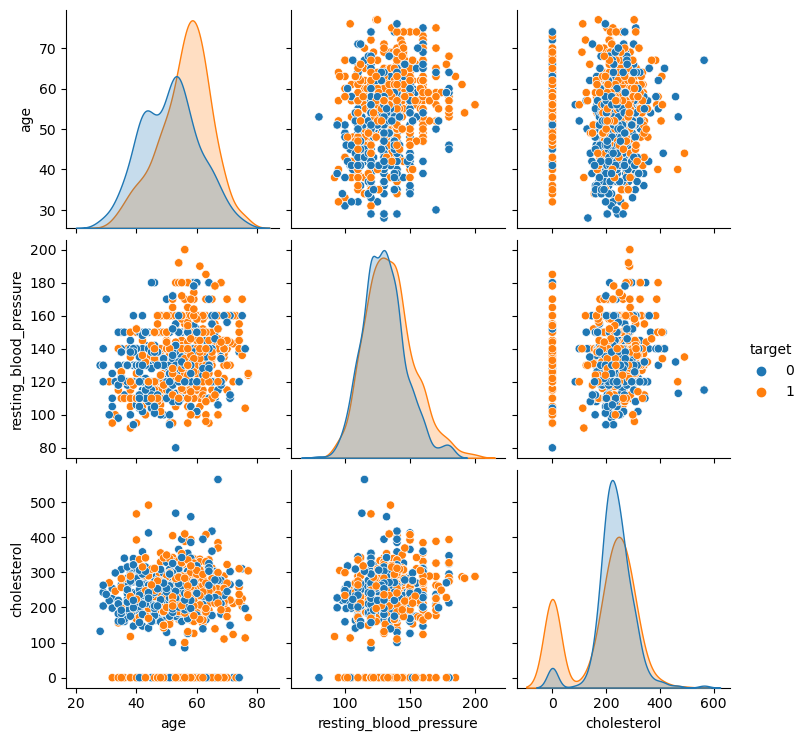

In [246]:
# plotting the distribution of numerical columns/features
sns.pairplot(df, hue = 'target', vars = ['age', 'resting_blood_pressure', 'cholesterol'] )

<Axes: xlabel='resting_blood_pressure', ylabel='cholesterol'>

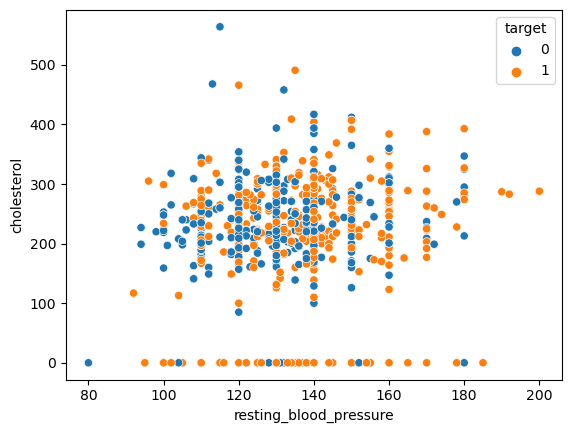

In [247]:
sns.scatterplot(x = 'resting_blood_pressure', y = 'cholesterol', hue = 'target', data = df)

<Axes: xlabel='resting_blood_pressure', ylabel='age'>

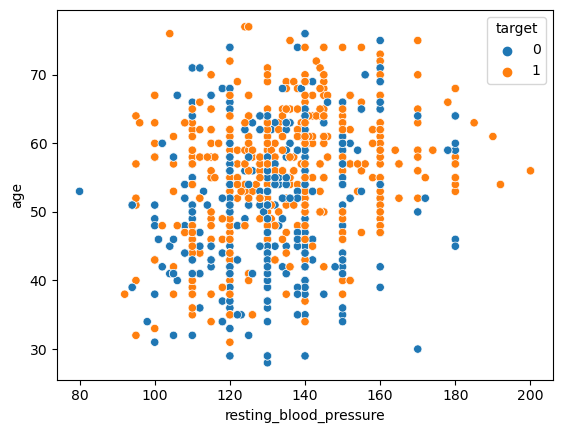

In [248]:
sns.scatterplot(x = 'resting_blood_pressure', y = 'age', hue = 'target', data = df)

In [260]:
## encoding categorical variables
df = pd.get_dummies(df, drop_first=True)

df.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
0,40,140,289,0,172,0,0.0,0,1,1,0,0,0,1,0,1
1,49,160,180,0,156,0,1.0,1,0,0,1,0,0,1,1,0
2,37,130,283,0,98,0,0.0,0,1,1,0,0,0,0,0,1
3,48,138,214,0,108,1,1.5,1,0,0,0,0,0,1,1,0
4,54,150,195,0,122,0,0.0,0,1,0,1,0,0,1,0,1


In [261]:
# splitting the dataframe into X and y
X = df.drop(['target'],axis=1)
y = df['target']

<Axes: title={'center': 'Correlation with heart disease'}>

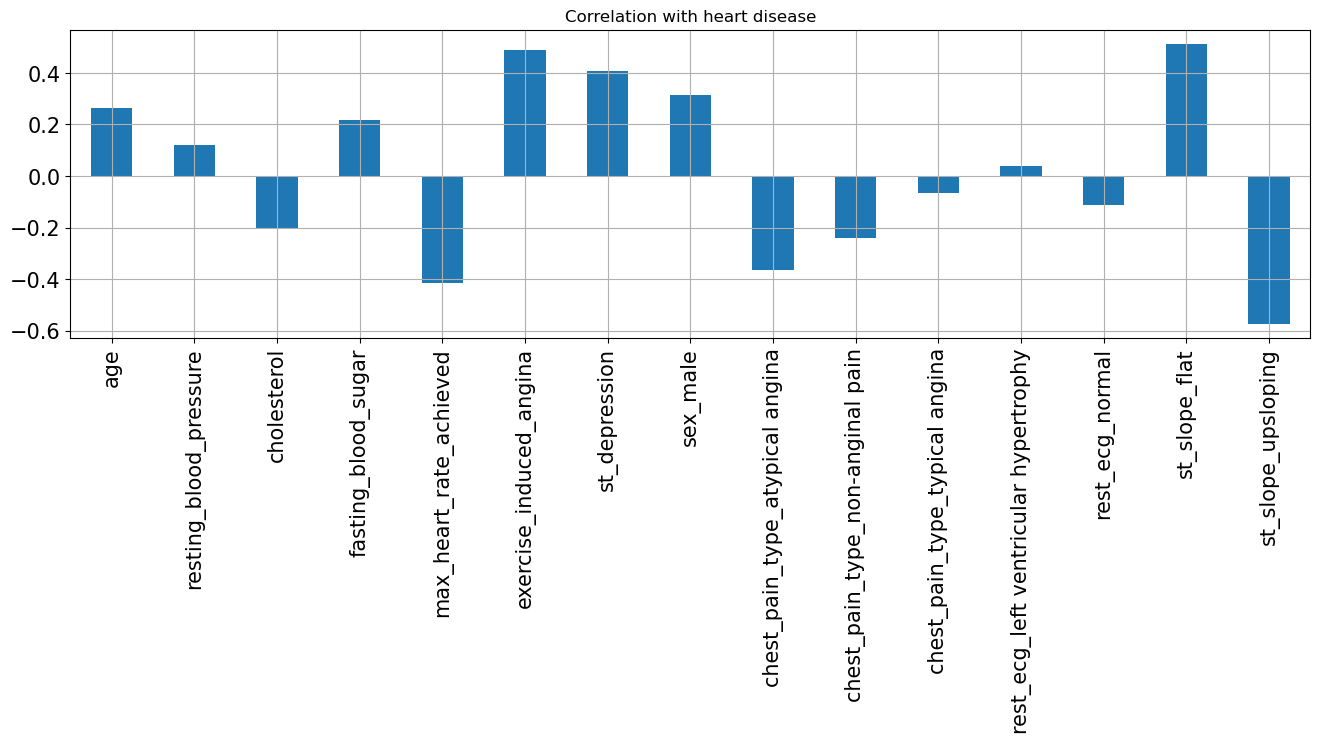

In [262]:
#Correlation with Response Variable class

X.corrwith(y).plot.bar(
        figsize = (16, 4), title = "Correlation with heart disease", fontsize = 15,
        rot = 90, grid = True)


Test and Train split

In [263]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [264]:
## checking distribution of target variable in train test split
print('Distribution of traget variable in training set')
print(y_train.value_counts())

print('Distribution of traget variable in test set')
print(y_test.value_counts())

Distribution of traget variable in training set
1    489
0    439
Name: target, dtype: int64
Distribution of traget variable in test set
1    123
0    110
Name: target, dtype: int64


In [265]:
print('------------Training Set------------------')
print(X_train.shape)
print(y_train.shape)

print('------------Test Set------------------')
print(X_test.shape)
print(y_test.shape)

------------Training Set------------------
(928, 15)
(928,)
------------Test Set------------------
(233, 15)
(233,)


Data Normalization

In [266]:
# Creating an instance of MinMaxScaler
# MinMaxScaler scales and translates each feature individually such that it is in the given range (usually between 0 and 1)
scaler = MinMaxScaler()

In [267]:
X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.fit_transform(X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_train.describe()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,0.525136,0.373024,0.376101,0.219828,0.536670,0.398707,0.354736,0.759698,0.185345,0.242457,0.054957,0.281250,0.562500,0.483836,0.453664
std,0.193026,0.159895,0.172685,0.414353,0.191811,0.489896,0.132055,0.427497,0.388787,0.428800,0.228019,0.449852,0.496346,0.500008,0.498117
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.387755,0.259259,0.342199,0.000000,0.398496,0.000000,0.243902,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.551020,0.351852,0.407801,0.000000,0.548872,0.000000,0.317073,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.653061,0.444444,0.478723,0.000000,0.684211,1.000000,0.426829,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [268]:
X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.fit_transform(X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_test.describe()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,0.478907,0.515021,0.358597,0.188841,0.599055,0.356223,0.359624,0.772532,0.167382,0.218884,0.055794,0.240343,0.622318,0.493562,0.407725
std,0.218869,0.188853,0.193566,0.392225,0.208066,0.479913,0.203075,0.420100,0.374120,0.414380,0.230018,0.428212,0.485851,0.501035,0.492470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.341463,0.400000,0.313830,0.000000,0.445378,0.000000,0.169811,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.487805,0.500000,0.400709,0.000000,0.613445,0.000000,0.339623,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.634146,0.600000,0.478723,0.000000,0.773109,1.000000,0.490566,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Model Selection and Evaluation with Baseline Machine Learning Models

In this step, we will build different baseline models and perform 10-fold cross validation to filter top performing baseline models to be used in level 0 of stacked ensemble method.

In [269]:
# defining a function to initialize baseline machine learning models
def GetBasedModel():
    basedModels = []
    # Appending tuples containing model names and their corresponding instances
    basedModels.append(('LR_L2', LogisticRegression(penalty='l2')))
    basedModels.append(('LDA', LinearDiscriminantAnalysis()))
    basedModels.append(('KNN7', KNeighborsClassifier(7)))
    basedModels.append(('KNN5', KNeighborsClassifier(5)))
    basedModels.append(('KNN9', KNeighborsClassifier(9)))
    basedModels.append(('KNN11', KNeighborsClassifier(11)))
    basedModels.append(('CART', DecisionTreeClassifier()))
    basedModels.append(('NB', GaussianNB()))
    basedModels.append(('SVM Linear', SVC(kernel='linear', gamma='auto', probability=True)))
    basedModels.append(('SVM RBF', SVC(kernel='rbf', gamma='auto', probability=True)))
    basedModels.append(('AB', AdaBoostClassifier()))
    basedModels.append(('GBM', GradientBoostingClassifier(n_estimators=100, max_features='sqrt')))
    basedModels.append(('RF_Ent100', RandomForestClassifier(criterion='entropy', n_estimators=100)))
    basedModels.append(('RF_Gini100', RandomForestClassifier(criterion='gini', n_estimators=100)))
    basedModels.append(('ET100', ExtraTreesClassifier(n_estimators=100)))
    basedModels.append(('ET500', ExtraTreesClassifier(n_estimators=500)))
    basedModels.append(('MLP', MLPClassifier()))
    basedModels.append(('SGD3000', SGDClassifier(max_iter=1000, tol=1e-4)))
    basedModels.append(('XGB_2000', xgb.XGBClassifier(n_estimators=2000)))
    basedModels.append(('XGB_500', xgb.XGBClassifier(n_estimators=500)))
    basedModels.append(('XGB_100', xgb.XGBClassifier(n_estimators=100)))
    basedModels.append(('XGB_1000', xgb.XGBClassifier(n_estimators=1000)))
    basedModels.append(('ET1000', ExtraTreesClassifier(n_estimators=1000)))
    
    return basedModels

def BasedLine2(X_train, y_train, models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'
    seed = 7
    results = []
    names = []
    messages = []  # Store messages for all models
    kfold = model_selection.KFold(n_splits=num_folds, shuffle=True, random_state=seed)  # Shuffle data outside of loop
    
    for name, model in models:
        # Perform cross-validation
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        # Print mean and standard deviation of accuracy for each model
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        messages.append(msg)  # Store message for each model
        print(msg)
        
    return results, messages  # Return messages for all models

In [270]:
models = GetBasedModel()
names, results = BasedLine2(X_train, y_train, models)

LR_L2: 0.844881 (0.058330)
LDA: 0.844869 (0.064221)
KNN7: 0.837260 (0.057542)
KNN5: 0.843747 (0.059384)
KNN9: 0.846973 (0.048765)
KNN11: 0.841585 (0.051397)
CART: 0.870664 (0.035135)
NB: 0.841608 (0.056776)
SVM Linear: 0.842742 (0.066822)
SVM RBF: 0.844881 (0.061795)
AB: 0.848083 (0.047590)
GBM: 0.895489 (0.037701)
RF_Ent100: 0.926753 (0.035692)
RF_Gini100: 0.920313 (0.037647)
ET100: 0.910589 (0.029332)
ET500: 0.911676 (0.032260)
MLP: 0.865323 (0.047525)
SGD3000: 0.831919 (0.059374)
XGB_2000: 0.904091 (0.034900)
XGB_500: 0.909479 (0.033441)
XGB_100: 0.906265 (0.036712)
XGB_1000: 0.906253 (0.034729)
ET1000: 0.911676 (0.032617)


Model Development

In [173]:
## Random Forest

# Initialize a RandomForestClassifier with criterion set to 'entropy' and 100 estimators
rf_ent = RandomForestClassifier(criterion='entropy', n_estimators=100)

# Train the RandomForestClassifier model on the training data (X_train and y_train)
rf_ent.fit(X_train, y_train)

# Use the trained model to make predictions on the test data (X_test)
y_pred_rfe = rf_ent.predict(X_test)

In [174]:
## Multi Layer Perceptron Classifier

# Initialize a Multi-Layer Perceptron (MLP) Classifier
mlp = MLPClassifier()

# Train the MLP Classifier model on the training data (X_train and y_train)
mlp.fit(X_train, y_train)

# Use the trained model to make predictions on the test data (X_test)
y_pred_mlp = mlp.predict(X_test)

In [175]:
## K Nearest Neighbors classifier

# Initialize a KNeighborsClassifier with 9 neighbors
knn = KNeighborsClassifier(9)

# Train the KNeighborsClassifier model on the training data (X_train and y_train)
knn.fit(X_train, y_train)

# Use the trained model to make predictions on the test data (X_test)
y_pred_knn = knn.predict(X_test)

In [179]:
## Extra Tree Classifier 

# Initialize an ExtraTreesClassifier model with 100 estimators
et_100 = ExtraTreesClassifier(n_estimators=100)

# Train the ExtraTreesClassifier model on the training data (X_train and y_train)
et_100.fit(X_train, y_train)

# Use the trained model to make predictions on the test data (X_test)
y_pred_et_100 = et_100.predict(X_test)

In [181]:
## XGBoost

# Initialize an XGBClassifier with 500 estimators
xgb = xgb.XGBClassifier(n_estimators=500)

# Train the XGBClassifier model on the training data (X_train and y_train)
xgb.fit(X_train, y_train)

# Use the trained model to make predictions on the test data (X_test)
y_pred_xgb = xgb.predict(X_test)

In [182]:
## Support vector Classifier

# Initialize a Support Vector Classifier (SVC) with a linear kernel and auto value for gamma, and enable probability estimation
svc = SVC(kernel='linear', gamma='auto', probability=True)

# Train the SVC model using the training data (X_train and y_train)
svc.fit(X_train, y_train)

# Use the trained SVC model to predict labels for the test data (X_test)
y_pred_svc = svc.predict(X_test)

In [183]:
## Stochastic Gradient Boosting

# Initialize a SGDClassifier with maximum iterations set to 1000 and tolerance set to 1e-4
sgd = SGDClassifier(max_iter=1000, tol=1e-4)

# Train the SGDClassifier model on the training data (X_train and y_train)
sgd.fit(X_train, y_train)

# Use the trained model to make predictions on the test data (X_test)
y_pred_sgd = sgd.predict(X_test)

In [184]:
## Adaboost Classifier

# Initialize an AdaBoostClassifier
ada = AdaBoostClassifier()

# Train the AdaBoostClassifier model on the training data (X_train and y_train)
ada.fit(X_train, y_train)

# Use the trained model to make predictions on the test data (X_test)
y_pred_ada = ada.predict(X_test)

In [185]:
## Decision Tree Classifier

# Initialize a DecisionTreeClassifier
decc = DecisionTreeClassifier()

# Train the DecisionTreeClassifier model on the training data (X_train and y_train)
decc.fit(X_train, y_train)

# Use the trained model to make predictions on the test data (X_test)
y_pred_decc = decc.predict(X_test)

In [186]:
# Gradient Boosting Classifier

# Initialize a GradientBoostingClassifier with 100 estimators and maximum features set to 'sqrt'
gbm = GradientBoostingClassifier(n_estimators=100, max_features='sqrt')

# Train the GradientBoostingClassifier model on the training data (X_train and y_train)
gbm.fit(X_train, y_train)

# Use the trained model to make predictions on the test data (X_test)
y_pred_gbm = gbm.predict(X_test)

Model Evaluation
 

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,Random Forest,0.906383,0.879699,0.95122,0.857143,0.914062,0.904181,3.233472,0.814595


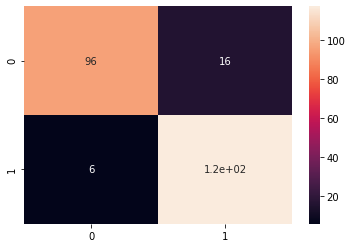

In [187]:
# Calculate the confusion matrix using y_test (true labels) and y_pred_rfe (predicted labels)
CM = confusion_matrix(y_test, y_pred_rfe)

# Create a heatmap of the confusion matrix with annotations
sns.heatmap(CM, annot=True)

# Calculate True Negative (TN), False Negative (FN), True Positive (TP), and False Positive (FP)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Calculate Specificity using TN and FP
specificity = TN / (TN + FP)

# Calculate log loss using true labels (y_test) and predicted labels (y_pred_rfe)
loss_log = log_loss(y_test, y_pred_rfe)

# Calculate accuracy score using true labels (y_test) and predicted labels (y_pred_rfe)
acc = accuracy_score(y_test, y_pred_rfe)

# Calculate ROC AUC score using true labels (y_test) and predicted labels (y_pred_rfe)
roc = roc_auc_score(y_test, y_pred_rfe)

# Calculate precision score using true labels (y_test) and predicted labels (y_pred_rfe)
prec = precision_score(y_test, y_pred_rfe)

# Calculate recall score using true labels (y_test) and predicted labels (y_pred_rfe)
rec = recall_score(y_test, y_pred_rfe)

# Calculate F1 score using true labels (y_test) and predicted labels (y_pred_rfe)
f1 = f1_score(y_test, y_pred_rfe)

# Calculate Matthews correlation coefficient using true labels (y_test) and predicted labels (y_pred_rfe)
mathew = matthews_corrcoef(y_test, y_pred_rfe)

# Create a DataFrame to store model results including Accuracy, Precision, Sensitivity, Specificity,
# F1 Score, ROC AUC, Log Loss, and Matthews correlation coefficient
model_results = pd.DataFrame([['Random Forest', acc, prec, rec, specificity, f1, roc, loss_log, mathew]],
                              columns=['Model', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity',
                                       'F1 Score', 'ROC', 'Log_Loss', 'Matthew_corrcoef'])

# Display the model results DataFrame
model_results

## Comparison with other Models

In [188]:
# Create a dictionary containing the predicted labels for each model
data = {'MLP': y_pred_mlp,
        'KNN': y_pred_knn,
        'EXtra tree classifier': y_pred_et_100,
        'XGB': y_pred_xgb,
        'SVC': y_pred_svc,
        'SGD': y_pred_sgd,
        'Adaboost': y_pred_ada,
        'CART': y_pred_decc,
        'GBM': y_pred_gbm}

# Create a DataFrame 'models' using the data dictionary
models = pd.DataFrame(data)

# Initialize an empty DataFrame 'model_results' to store evaluation metrics for each model
model_results = pd.DataFrame()

# Iterate through each column (model) in the 'models' DataFrame
for column in models:
    # Calculate the confusion matrix for the current model
    CM = confusion_matrix(y_test, models[column])
    
    # Extract True Negative (TN), False Negative (FN), True Positive (TP), and False Positive (FP) from the confusion matrix
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    # Calculate specificity using TN and FP
    specificity = TN / (TN + FP)
    
    # Calculate log loss using true labels (y_test) and predicted labels for the current model
    loss_log = log_loss(y_test, models[column])
    
    # Calculate accuracy score using true labels (y_test) and predicted labels for the current model
    acc = accuracy_score(y_test, models[column])
    
    # Calculate ROC AUC score using true labels (y_test) and predicted labels for the current model
    roc = roc_auc_score(y_test, models[column])
    
    # Calculate precision score using true labels (y_test) and predicted labels for the current model
    prec = precision_score(y_test, models[column])
    
    # Calculate recall score using true labels (y_test) and predicted labels for the current model
    rec = recall_score(y_test, models[column])
    
    # Calculate F1 score using true labels (y_test) and predicted labels for the current model
    f1 = f1_score(y_test, models[column])
    
    # Calculate Matthews correlation coefficient using true labels (y_test) and predicted labels for the current model
    mathew = matthews_corrcoef(y_test, models[column])
    
    # Create a DataFrame 'results' containing evaluation metrics for the current model
    results = pd.DataFrame([[column, acc, prec, rec, specificity, f1, roc, loss_log, mathew]],
                           columns=['Model', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score', 'ROC', 'Log_Loss', 'Matthew_corrcoef'])
    
    # Append the 'results' DataFrame to 'model_results'
    model_results = model_results.append(results, ignore_index=True)

# Display the final DataFrame 'model_results' containing evaluation metrics for all models
model_results

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,Random Forest,0.906383,0.879699,0.951220,0.857143,0.914062,0.904181,3.233472,0.814595
1,MLP,0.825532,0.801471,0.886179,0.758929,0.841699,0.822554,6.026006,0.652539
2,KNN,0.808511,0.786765,0.869919,0.741071,0.826255,0.805495,6.613907,0.618029
3,EXtra tree classifier,0.897872,0.883721,0.926829,0.866071,0.904762,0.896450,3.527415,0.795852
4,XGB,0.919149,0.906250,0.943089,0.892857,0.924303,0.917973,2.792538,0.838384
5,SVC,0.825532,0.801471,0.886179,0.758929,0.841699,0.822554,6.026006,0.652539
6,SGD,0.791489,0.862745,0.715447,0.875000,0.782222,0.795224,7.201750,0.595000
7,Adaboost,0.834043,0.813433,0.886179,0.776786,0.848249,0.831482,5.732052,0.668866
8,CART,0.834043,0.833333,0.853659,0.812500,0.843373,0.833079,5.732039,0.667176
9,GBM,0.851064,0.833333,0.894309,0.803571,0.862745,0.848940,5.144148,0.702485


### Findings
- AS we can see from above results, XGBoost Classifier is best performer as it has highest test accuracy of 0.9191, sensitivity of 0.943 and specificity of 0.89 and highest f1-score of 0.9243 and lowest Log Loss of 2079.


### ROC AUC Curve

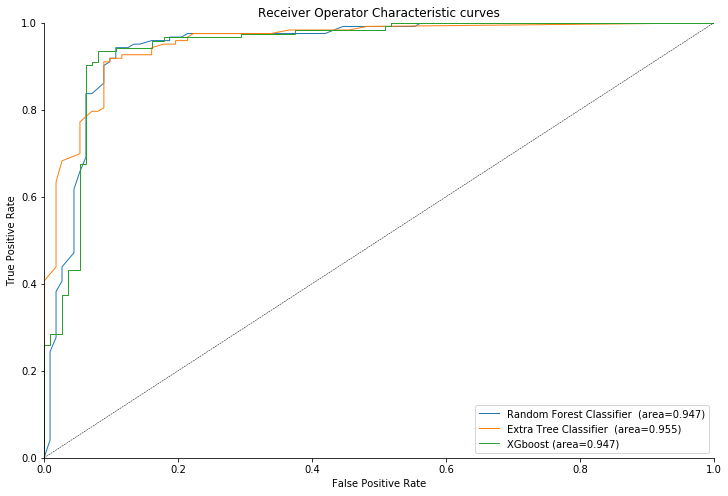

In [189]:
# Define a function roc_auc_plot to plot ROC curves and calculate AUC scores
def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    # Import necessary libraries
    from sklearn.metrics import roc_curve, roc_auc_score
    
    # Calculate false positive rate (fpr), true positive rate (tpr), and thresholds
    fpr, tpr, _ = roc_curve(y_true, y_proba[:,1])
    
    # Plot the ROC curve
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)" % (label, roc_auc_score(y_true, y_proba[:,1])))

# Create a new figure and axis for plotting
f, ax = plt.subplots(figsize=(12,8))

# Plot ROC curve and calculate AUC score for Random Forest Classifier
roc_auc_plot(y_test, rf_ent.predict_proba(X_test), label='Random Forest Classifier ', l='-')

# Plot ROC curve and calculate AUC score for Extra Tree Classifier
roc_auc_plot(y_test, et_100.predict_proba(X_test), label='Extra Tree Classifier ', l='-')

# Plot ROC curve and calculate AUC score for XGBoost
roc_auc_plot(y_test, xgb.predict_proba(X_test), label='XGboost', l='-')

# Plot the diagonal line representing random guessing
ax.plot([0,1], [0,1], color='k', linewidth=0.5, linestyle='--')

# Add a legend to the plot
ax.legend(loc="lower right")

# Set labels for x-axis and y-axis
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Set limits for x-axis and y-axis
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Set title for the plot
ax.set_title('Receiver Operator Characteristic curves')

# Remove the spines from the plot
sns.despine()

As we can see highest average area under the curve (AUC) of 0.950 is attained by Extra Tree Classifier

## Precision Recall curve

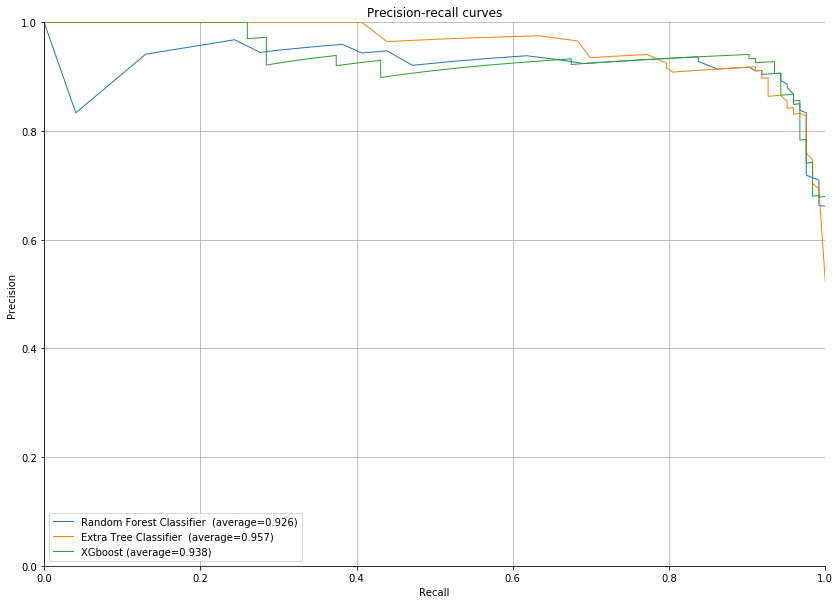

In [190]:
# Define a function precision_recall_plot that plots precision-recall curves for given true labels and predicted probabilities
def precision_recall_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    # Import necessary functions from sklearn.metrics
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    # Calculate precision, recall, and thresholds using precision_recall_curve function
    precision, recall, _ = precision_recall_curve(y_test, y_proba[:,1])
    
    # Calculate average precision score using average_precision_score function
    average_precision = average_precision_score(y_test, y_proba[:,1], average="micro")
    
    # Plot precision-recall curve
    ax.plot(recall, precision, label='%s (average=%.3f)'%(label,average_precision),
            linestyle=l, linewidth=lw)

# Create a figure and axis for plotting
f, ax = plt.subplots(figsize=(14,10))

# Plot precision-recall curves for different classifiers using the defined function
precision_recall_plot(y_test,rf_ent.predict_proba(X_test),label='Random Forest Classifier ',l='-')
precision_recall_plot(y_test,et_100.predict_proba(X_test),label='Extra Tree Classifier ',l='-')
precision_recall_plot(y_test,xgb.predict_proba(X_test),label='XGboost',l='-')

# Set labels and legend for the plot
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc="lower left")

# Set limits for x and y axes
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Set title for the plot
ax.set_title('Precision-recall curves')

# Remove spines from the plot
sns.despine()


### 11.  Feature Selection

In [191]:
num_feats=11

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

11 selected features


In [192]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

11 selected features


In [193]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 15 features.
11 selected features


In [194]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2", solver='lbfgs'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

7 selected features


In [195]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, criterion='gini'), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

8 selected features


In [196]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

7 selected features


In [197]:
# put all selection together
feature_name = X.columns
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,st_slope_flat,True,True,True,True,True,True,6
2,st_depression,True,True,True,True,True,True,6
3,max_heart_rate_achieved,True,True,True,False,True,True,5
4,exercise_induced_angina,True,True,True,False,True,True,5
5,cholesterol,True,False,True,True,True,True,5
6,age,True,True,True,False,True,True,5
7,st_slope_upsloping,True,True,True,False,True,False,4
8,sex_male,True,True,True,True,False,False,4
9,chest_pain_type_non-anginal pain,True,True,True,True,False,False,4
10,chest_pain_type_atypical angina,True,True,True,True,False,False,4


In [198]:
# segregating dataset into features i.e., X and target variables i.e., y
X = dt.drop(['target','resting_blood_pressure','sex_male','chest_pain_type_non-anginal pain','chest_pain_type_atypical angina'],axis=1)
y = dt['target']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [200]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[['age','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.fit_transform(X_train[['age','cholesterol','max_heart_rate_achieved','st_depression']])
X_train.head()

,age,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
478,0.673469,0.000000,1,0.303704,1,0.454545,0,0,1,0,0
253,0.673469,0.594705,0,0.355556,1,0.194805,0,0,0,0,1
273,0.551020,0.409369,0,0.466667,1,0.584416,0,0,1,1,0
111,0.591837,0.519348,0,0.185185,1,0.584416,0,0,1,1,0
50,0.448980,0.474542,0,0.400000,1,0.454545,0,0,1,1,0


In [201]:
X_test[['age','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.transform(X_test[['age','cholesterol','max_heart_rate_achieved','st_depression']])
X_test.head()

,age,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
1024,0.693878,0.572301,0,0.266667,0,0.376623,0,1,0,1,0
182,0.469388,0.456212,0,0.614815,0,0.194805,0,0,1,0,1
785,0.346939,0.480652,0,0.629630,1,0.220779,0,1,0,1,0
924,0.591837,0.562118,0,0.333333,1,0.272727,0,1,0,1,0
780,0.612245,0.527495,0,0.466667,1,0.584416,0,1,0,1,0


In [202]:
import xgboost as xgb
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)

LR_L2: 0.822878 (0.047967)
LDA: 0.822867 (0.043305)
KNN7: 0.807904 (0.044339)
KNN5: 0.803660 (0.045820)
KNN9: 0.815374 (0.036848)
KNN11: 0.809037 (0.042388)
CART: 0.879398 (0.026636)
NB: 0.822889 (0.042157)
SVM Linear: 0.815488 (0.045773)
SVM RBF: 0.797278 (0.049967)
AB: 0.816529 (0.036133)
GBM: 0.861290 (0.024561)
RF_Ent100: 0.922123 (0.023723)
RF_Gini100: 0.916781 (0.028405)
ET100: 0.919995 (0.030889)
ET500: 0.918909 (0.023832)
MLP: 0.840963 (0.036146)
SGD3000: 0.816381 (0.041746)
XGB_2000: 0.900766 (0.042812)
XGB_500: 0.887943 (0.039344)
XGB_100: 0.850583 (0.028564)
XGB_1000: 0.906074 (0.044921)
ET1000: 0.918897 (0.024810)


## Soft voting

In [203]:
import xgboost as xgb
clf1=RandomForestClassifier(criterion='entropy',n_estimators=100)

clf2=DecisionTreeClassifier()
clf3=xgb.XGBClassifier(n_estimators= 1000)
clf4=ExtraTreesClassifier(n_estimators= 500)

clf5=GradientBoostingClassifier(n_estimators=100,max_features='sqrt')


eclf1 = VotingClassifier(estimators=[('rfe', clf1), ('decc', clf2), ('xgb', clf3),('ET',clf4),('gb',clf5),], 
                         voting='soft', weights=[4,1,2,3,1])
eclf1.fit(X_train,y_train)
y_pred_sv =eclf1.predict(X_test)

## 12 Model Evaluation

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,Soft Voting,0.897872,0.87218,0.943089,0.848214,0.90625,0.895652,3.527422,0.797405


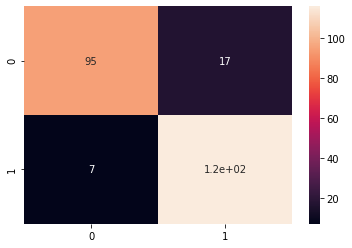

In [204]:
CM=confusion_matrix(y_test,y_pred_sv)
sns.heatmap(CM, annot=True)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
loss_log = log_loss(y_test, y_pred_sv)
acc= accuracy_score(y_test, y_pred_sv)
roc=roc_auc_score(y_test, y_pred_sv)
prec = precision_score(y_test, y_pred_sv)
rec = recall_score(y_test, y_pred_sv)
f1 = f1_score(y_test, y_pred_sv)

mathew = matthews_corrcoef(y_test, y_pred_sv)
model_results =pd.DataFrame([['Soft Voting',acc, prec,rec,specificity, f1,roc, loss_log,mathew]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef'])

model_results

In [205]:
rf_ent = RandomForestClassifier(criterion='entropy',n_estimators=100)
rf_ent.fit(X_train, y_train)
y_pred_rfe = rf_ent.predict(X_test)

In [206]:
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
y_pred_mlp = mlp.predict(X_test)

In [207]:
knn = KNeighborsClassifier(9)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

In [208]:
et_1000 = ExtraTreesClassifier(n_estimators= 1000)
et_1000.fit(X_train,y_train)
y_pred_et1000 = et_1000.predict(X_test)

In [209]:
xgb = xgb.XGBClassifier(n_estimators= 1000)
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

In [210]:
svc = SVC(kernel='linear',gamma='auto',probability=True)
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)

In [211]:
sgd = SGDClassifier(max_iter=1000, tol=1e-4)
sgd.fit(X_train,y_train)
y_pred_sgd = sgd.predict(X_test)

In [212]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred_ada = ada.predict(X_test)

In [213]:
decc = DecisionTreeClassifier()
decc.fit(X_train,y_train)
y_pred_decc = decc.predict(X_test)

In [214]:
gbm = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbm.fit(X_train,y_train)
y_pred_gbm = gbm.predict(X_test)

In [215]:
data = {
             'Random Forest Entropy': y_pred_rfe, 
                'MLP2': y_pred_mlp, 
                'KNN2': y_pred_knn, 
                'EXtra tree classifier': y_pred_et1000,
                'XGB2': y_pred_xgb, 
                'SVC2': y_pred_svc, 
                'SGD2': y_pred_sgd,
                'Adaboost': y_pred_ada, 
                'CART': y_pred_decc, 
                'GBM': y_pred_gbm }

models = pd.DataFrame(data) 
 
for column in models:
    CM=confusion_matrix(y_test,models[column])
    
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    specificity = TN/(TN+FP)
    loss_log = log_loss(y_test, models[column])
    acc= accuracy_score(y_test, models[column])
    roc=roc_auc_score(y_test, models[column])
    prec = precision_score(y_test, models[column])
    rec = recall_score(y_test, models[column])
    f1 = f1_score(y_test, models[column])
    
    mathew = matthews_corrcoef(y_test, models[column])
    results =pd.DataFrame([[column,acc, prec,rec,specificity, f1,roc, loss_log,mathew]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef'])
    model_results = model_results.append(results, ignore_index = True)

model_results

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,Soft Voting,0.897872,0.872180,0.943089,0.848214,0.906250,0.895652,3.527422,0.797405
1,Random Forest Entropy,0.902128,0.873134,0.951220,0.848214,0.910506,0.899717,3.380449,0.806549
2,MLP2,0.821277,0.813953,0.853659,0.785714,0.833333,0.819686,6.172969,0.641753
3,KNN2,0.812766,0.806202,0.845528,0.776786,0.825397,0.811157,6.466920,0.624631
4,EXtra tree classifier,0.897872,0.877863,0.934959,0.857143,0.905512,0.896051,3.527419,0.796509
5,XGB2,0.897872,0.872180,0.943089,0.848214,0.906250,0.895652,3.527422,0.797405
6,SVC2,0.808511,0.778571,0.886179,0.723214,0.828897,0.804697,6.613914,0.620202
7,SGD2,0.821277,0.804511,0.869919,0.767857,0.835938,0.818888,6.172976,0.642693
8,Adaboost,0.825532,0.825397,0.845528,0.803571,0.835341,0.824550,6.025989,0.650092
9,CART,0.876596,0.856061,0.918699,0.830357,0.886275,0.874528,4.262297,0.753998


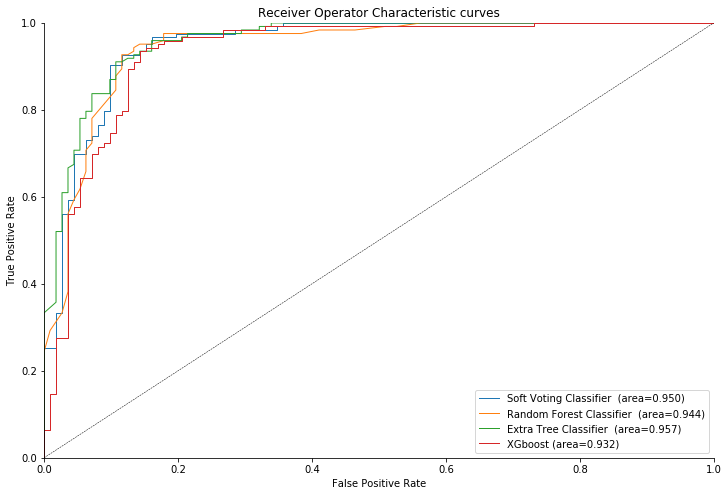

In [216]:
def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_proba[:,1])
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(y_true, y_proba[:,1])))

f, ax = plt.subplots(figsize=(12,8))

roc_auc_plot(y_test,eclf1.predict_proba(X_test),label='Soft Voting Classifier ',l='-')
roc_auc_plot(y_test,rf_ent.predict_proba(X_test),label='Random Forest Classifier ',l='-')
roc_auc_plot(y_test,et_1000.predict_proba(X_test),label='Extra Tree Classifier ',l='-')
roc_auc_plot(y_test,xgb.predict_proba(X_test),label='XGboost',l='-')

ax.plot([0,1], [0,1], color='k', linewidth=0.5, linestyle='--', 
        )    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operator Characteristic curves')
sns.despine()

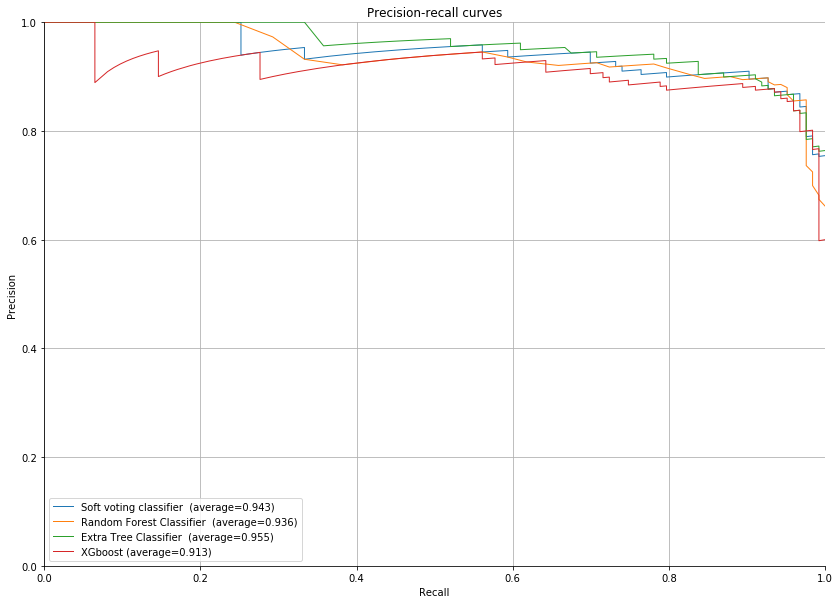

In [218]:
def precision_recall_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test,
                                                  y_proba[:,1])
    average_precision = average_precision_score(y_test, y_proba[:,1],
                                                     average="micro")
    ax.plot(recall, precision, label='%s (average=%.3f)'%(label,average_precision),
            linestyle=l, linewidth=lw)

f, ax = plt.subplots(figsize=(14,10))
precision_recall_plot(y_test,eclf1.predict_proba(X_test),label='Soft voting classifier ',l='-')
precision_recall_plot(y_test,rf_ent.predict_proba(X_test),label='Random Forest Classifier ',l='-')
precision_recall_plot(y_test,et_1000.predict_proba(X_test),label='Extra Tree Classifier ',l='-')
precision_recall_plot(y_test,xgb.predict_proba(X_test),label='XGboost',l='-')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc="lower left")
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Precision-recall curves')
sns.despine()

## Feature Importance

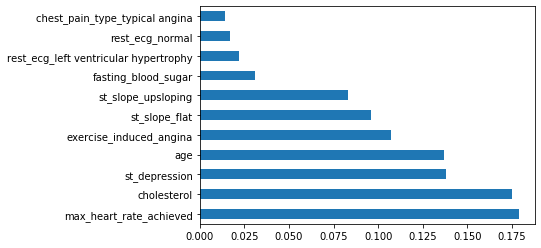

In [219]:
feat_importances = pd.Series(rf_ent.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

## Conclusion  <a id='data-conc'></a>

- As we can see, stacked ensemble of machine learning algorithms resulted in higher performance than any individual machine learning model.
- The second best performing algorithm is Random forest
- The top 5 contribution features are:
1. **Max heart Rate achieved**<br>
2. **Cholestrol**<br>
3. **st_depression**<br>
4. **Age**<br>
5. **exercise_induced_angina**<br>